# Post-process: Smoothing and Reclassify Classes

## Description
In this notebook we use external layers that contain reliable information on centain classes and/or have higher-spatial resolution to reclassify classes that may be misclassified by the random forest classifier. These external layers have been prepared and uploaded into 'Data/' folder. We'll also conduct a median filtering to reduce the 'salt and pepper' effect resulted from pixel-based classification. This notebook will demonstrate how to do these and visualise the comparison before and after the post-processing.

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load Packages

In [6]:
%matplotlib inline
import os
import datacube
import warnings
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray
from rasterio.enums import Resampling
from datacube.utils.cog import write_cog
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.plotting import rgb, display_map
from skimage.morphology import binary_dilation,disk
from skimage.filters.rank import modal
from odc.algo import xr_reproject
import matplotlib.pyplot as plt

## Analysis parameters
* `prediction_maps_path`: A list of file paths and names of the classification maps produced in the previous notebook.
* `rgb_images_path`: A list of file paths and names of the true colour images at the prediction locations exported in the previous notebook.
* `dict_map`: A dictionary map of class names corresponding to pixel values.
* `output_crs`: Coordinate reference system for output raster files.

In [7]:
prediction_maps_path=['Results/Rwanda_land_cover_prediction_2021_location_0.tif',
                      'Results/Rwanda_land_cover_prediction_2021_location_1.tif',
                      'Results/Rwanda_land_cover_prediction_2021_location_2.tif'] # list of prediction map files
rgb_images_path=['Results/Rwanda_satellite_image_2021_location_0.tif',
                'Results/Rwanda_satellite_image_2021_location_1.tif',
                'Results/Rwanda_satellite_image_2021_location_2.tif'] # list of rgb images at the prediction locations
dict_map={'Forest':1,'Grassland':5,'Shrubland':7,'Perennial Cropland':9,'Annual Cropland':10,
          'Wetland':11,'Water Body':12,'Urban Settlement':13}
output_crs='epsg:32735' # WGS84/UTM Zone 35S

## External Layers
A few external layers were sourced and prepared in the 'Data/' folder, which are helpful to provide information on specific classes, e.g. Urban Settlements and Water Body. which include:
* `hand_raster`: Hydrologically adjusted elevations, i.e. Height Above the Nearest Drainage (hand) derived from the [MERIT Hydro dataset](https://developers.google.com/earth-engine/datasets/catalog/MERIT_Hydro_v1_0_1#description).
* `river_network_shp`: OSM river network shapefile. The OSM layers were sourced from the [Humanitarian OpenStreetMap Team (HOT)](https://data.humdata.org/organization/hot) website.
* `road_network_shp`: OSM road network shapefile.
* `google_building_raster`: A rasterised layer of [Google Open Building polygons](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_Research_open-buildings_v2_polygons), which consist of outlines of buildings derived from high-resolution 50 cm satellite imagery. As there are many polygons in the original vector layer, we rasterised the layer to 10 m resolution to reduce disk storage and memory required for processing.
* `wsf2019_raster`: 2019 [World Settlement Footprint (WSF) layer](https://gee-community-catalog.org/projects/wsf/), a 10m resolution binary mask outlining the extent of human settlements globally derived by means of 2019 multitemporal Sentinel-1 and Sentinel-2 imagery.  

> Note: In this notebook we have made the data prepared for you to run through the demonstration. If you would like to apply it to your own project, you may need to spend some time sourcing the datasets and do some pre-processing if needed, e.g. clipping to your study area, filtering, rasterisation or vectorisation. Alternatively you can revise this notebook depending on your data format.

In [8]:
river_network_shp='Data/hotosm_rwa_waterways_lines_filtered.shp' # OSM river network data
road_network_shp='Data/hotosm_rwa_roads_lines_filtered.shp' # OSM road network data
google_building_raster='Data/GoogleBuildingLayer_Rwanda_reprojected_rasterised.tif' # rasterised google bulding layer
hand_raster='Data/hand_Rwanda.tif' # Hydrologically adjusted elevations, i.e. height above the nearest drainage (hand)
wsf2019_raster='Data/WSF2019_v1_Rwanda_clipped.tif' # 2019 World Settlement Footprint layer

## Load layers
First let's load the land cover maps and true colour images generated from the previous notebook:

In [41]:
# import land cover map of 2021 and reproject
prediction_maps=[]
rgb_images=[]
for i in range(0, len(prediction_maps_path)):
    lc_map=rioxarray.open_rasterio(prediction_maps_path[i]).astype(np.uint8).squeeze()
    prediction_maps.append(lc_map)
    
    rgb_image=rioxarray.open_rasterio(rgb_images_path[i])
    rgb_images.append(rgb_image)

We then load other layers. The SOM road network layer contains multi-lines with various surface attributes. We'll select some major road types and buffer them by 10 metres:

In [10]:
# import OSM road network data and reproject
road_network=gpd.read_file(road_network_shp).to_crs(output_crs) 
road_network=road_network.loc[road_network['surface'].isin(['asphalt', 'paved', 'compacted', 'cobblestone', 
                                                             'concrete', 'metal', 'paving_stones', 
                                                             'paving_stones:30'])] # select road network by attributes
road_network.geometry=road_network.geometry.buffer(10) # buffer the road network by 10m

Similaryly we load and select major waterways from the OSM river network layer:

In [11]:
river_network=gpd.read_file(river_network_shp).to_crs(output_crs) # import OSM river network data and reproject
river_network=river_network.loc[river_network['waterway'].isin(['canal','river'])] # select river network by attribute

We now load the Google buildings, WSF 2019 and 'hand' rasters:

In [12]:
google_buildings=xr.open_dataset(google_building_raster,engine="rasterio").squeeze() # import google bulding layer
hand=xr.open_dataset(hand_raster,engine="rasterio").squeeze() # import hand layer
wsf2019=xr.open_dataset(wsf2019_raster,engine="rasterio").astype(np.uint8).squeeze()

## Morphological filtering
Now we start the post-processing by applying a majority filtering, a commonly applied step to reduce salt-and-pepper noise typical in pixel-based classification. To demonstrate each post-processing step we will process the first prediction map, then put the steps together in an iterative loop to process all prediction. The majority filtering is applied within each local window with a given footprint. Here we use a disk with radius of one pixel. It is advised that you adjust the footprint depending on your prediction results and desired effects.

In [14]:
i=0
lc_map=prediction_maps[i]
# convert to numpy array
np_lc_map=lc_map.squeeze().to_numpy()
# mode filtering for a smoother classification map
np_lc_map_postproc=modal(np_lc_map,footprint=disk(1),mask=np_lc_map!=0)

We can plot and compare the maps before and after filtering:

Text(0.5, 1.0, 'Classified Image After Majority Filtering')

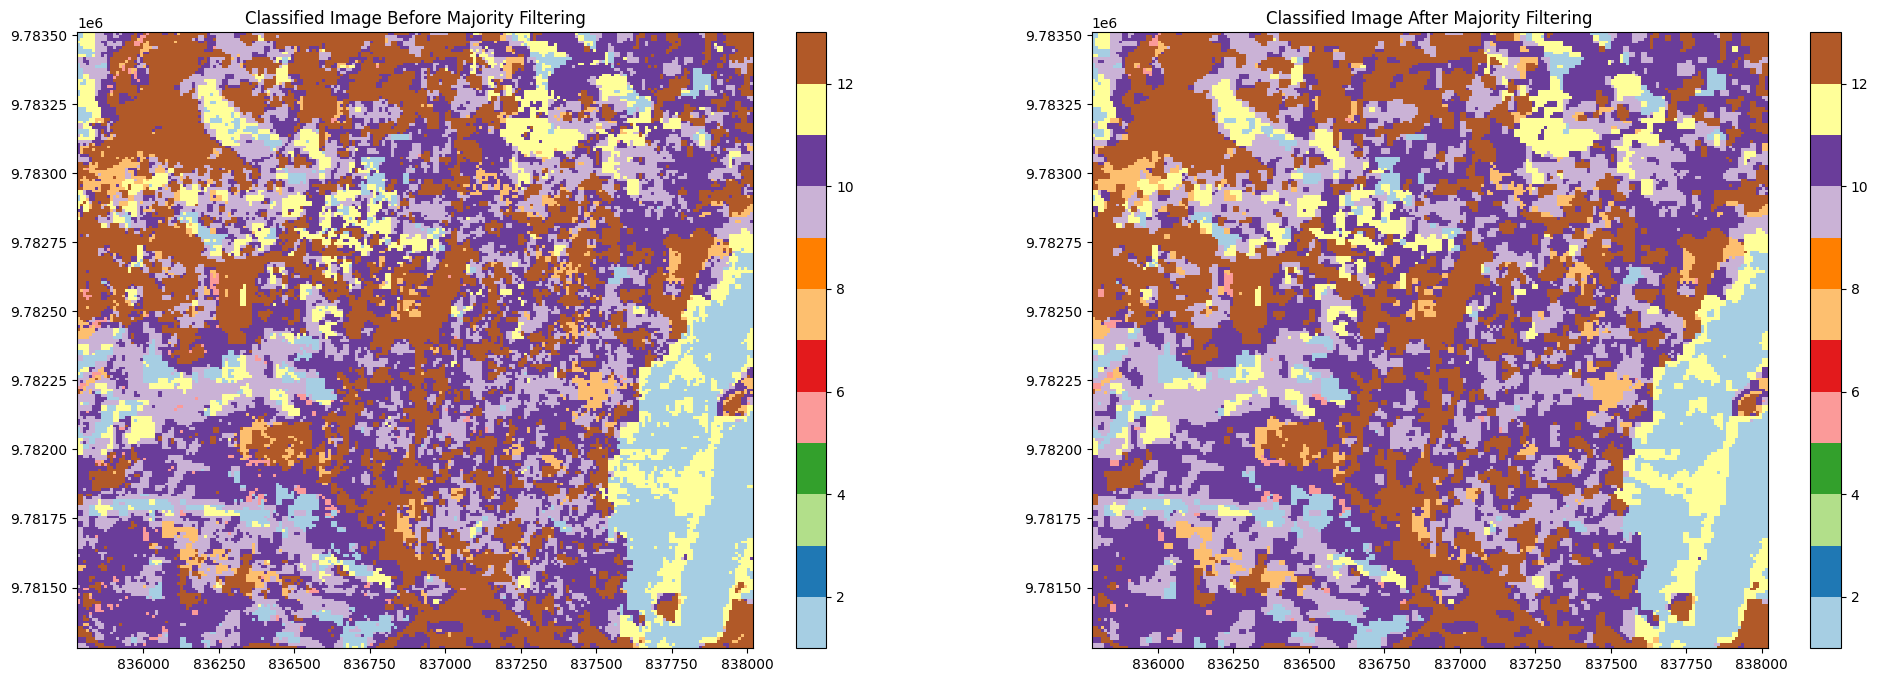

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Plot classified image before filtering
lc_map.plot(ax=axes[0], 
                   cmap='Paired', 
               add_labels=False, 
               add_colorbar=True)

# reconstruct dataArray
lc_map_postproc=xr.DataArray(data=np_lc_map_postproc,dims=['y','x'],
                             coords={'y':lc_map.y.to_numpy(), 'x':lc_map.x.to_numpy()})
# Plot classified image after filtering
lc_map_postproc.plot(ax=axes[1], 
                   cmap='Paired', 
               add_labels=False, 
               add_colorbar=True)

# Add plot titles
axes[0].set_title('Classified Image Before Majority Filtering')
axes[1].set_title('Classified Image After Majority Filtering')

## Apply rules using external layers
Before applying reclassification using other layers, one thing to note for raster-based calculation is to make sure all rasters are in the same spatial reference and align with each other. Here we extract the `geobox` of the land cover map, which defines the location and resolution of the grid data including spatial reference. We will use it to reproject other layers to be aligned with the land cover map.

In [16]:
ds_geobox=lc_map.geobox

Now let's reclassify some classes using the external layers. First, we reclassify pixels classified as water occuring at bottom of watersheds, i.e. height above nearest drainage below 45 m, or falling within OSM river networks as water class:

In [17]:
# reproject hand layer
hand=xr_reproject(hand, ds_geobox, resampling="average")
# convert to numpy array
np_hand=hand.to_array().squeeze().to_numpy()
# rasterise river network layer
river_network_mask=xr_rasterize(gdf=river_network,
                                  da=lc_map.squeeze(),
                                  transform=ds_geobox.transform,
                                  crs=output_crs)
# convert to numpy array
np_river_network_mask=river_network_mask.to_numpy()
# apply the rule
np_lc_map_postproc[((np_lc_map==dict_map['Water Body'])&(np_hand<=45))
                   |(np_river_network_mask==1)]=dict_map['Water Body']

We then assign pixels overlapping google building polygons or WSF 2019 mask as built-up:

In [18]:
# reproject google buildings raster
google_buildings_mask=xr_reproject(google_buildings, ds_geobox, resampling="average")
# convert to numpy array
np_google_buildings_mask=google_buildings_mask.to_array().squeeze().to_numpy()
# reproject WSF 2019 layer
wsf2019=xr_reproject(wsf2019, ds_geobox, resampling="nearest")
# convert to numpy array
np_wsf2019=wsf2019.to_array().squeeze().to_numpy()
# apply rule
np_lc_map_postproc[(np_google_buildings_mask==1)|(np_wsf2019==1)]=dict_map['Urban Settlement']

Moreover, we assume that Wetland should not be too close (e.g. within 50m) to Urban Settlement and reclassify these misclassified pixels as Annual Cropland instead:

In [19]:
# buffer Urban Settlement areas
urban_buffered=binary_dilation(np_lc_map==dict_map['Urban Settlement'],footprint=disk(5))
# apply rule
np_lc_map_postproc[(urban_buffered==1)&(np_lc_map==dict_map['Wetland'])]=dict_map['Annual Cropland']

In addition, we assign pixels overlapping OSM road network as Urban Settlement class:

In [20]:
# rasterise road network layer
road_network_mask=xr_rasterize(gdf=road_network,
                              da=lc_map.squeeze(),
                              transform=ds_geobox.transform,
                              crs=output_crs)
# convert to numpy
np_road_network_mask=road_network_mask.to_numpy()
# apply the rule
np_lc_map_postproc[np_road_network_mask==1]=dict_map['Urban Settlement']

We can plot the maps to see a comparison before and after applying the rules using the external layers:

Text(0.5, 1.0, 'Classified Image After Applying Rules')

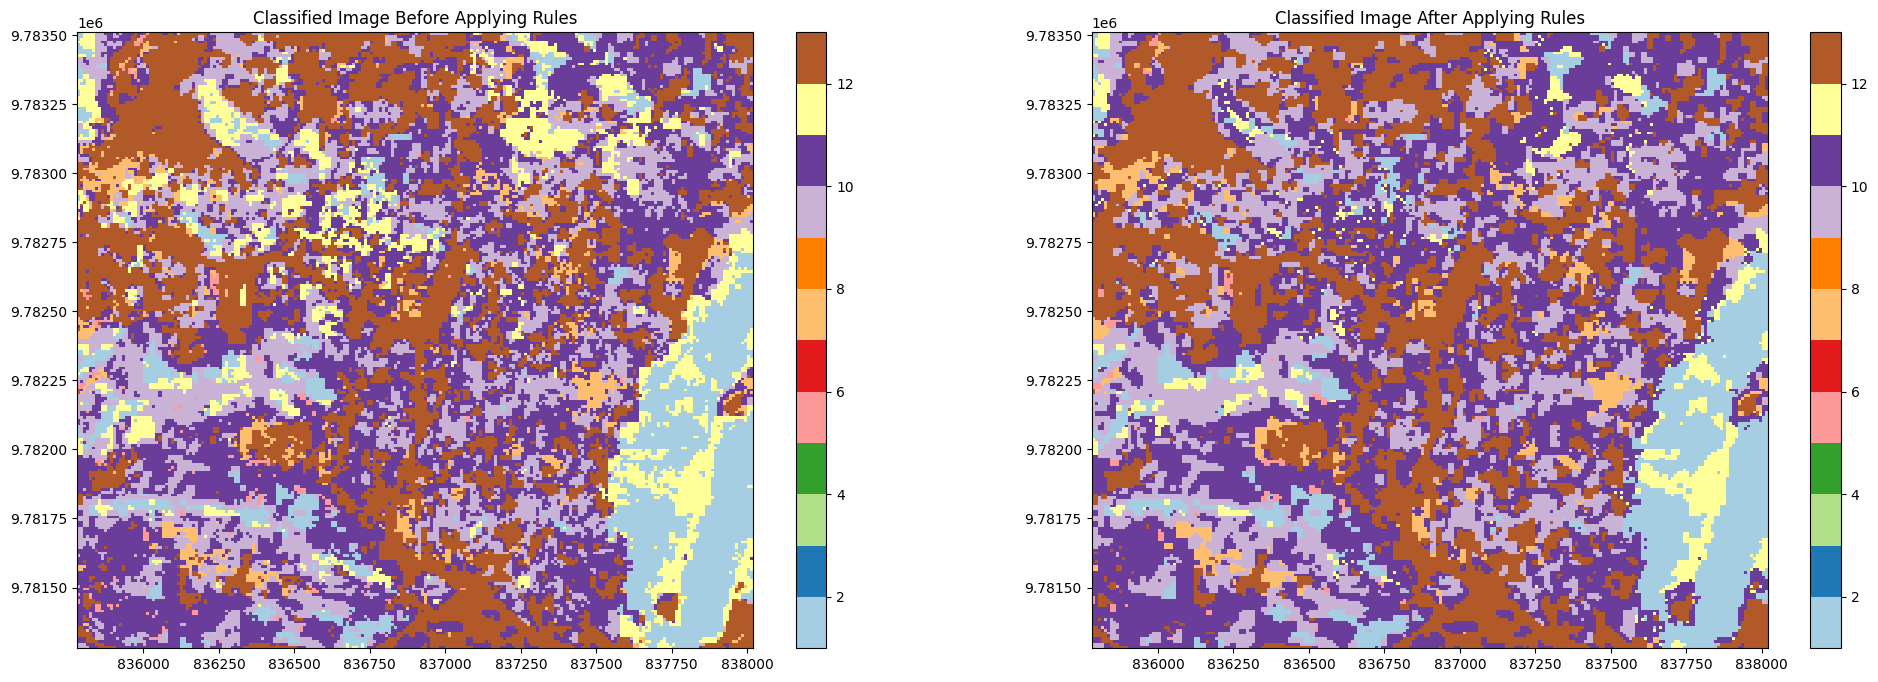

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Plot classified image before filtering
lc_map.plot(ax=axes[0], 
                cmap='Paired', 
               add_labels=False, 
               add_colorbar=True)

# reconstruct dataArray
lc_map_postproc=xr.DataArray(data=np_lc_map_postproc,dims=['y','x'],
                             coords={'y':lc_map.y.to_numpy(), 'x':lc_map.x.to_numpy()})
# set spatial reference
lc_map_postproc.rio.write_crs(output_crs, inplace=True)
# Plot classified image after filtering
lc_map_postproc.plot(ax=axes[1], 
                cmap='Paired', 
               add_labels=False, 
               add_colorbar=True)

# Add plot titles
axes[0].set_title('Classified Image Before Applying Rules')
axes[1].set_title('Classified Image After Applying Rules')

Now let's simply copy all the post-processing steps and put together, then iterate through all three locations and store all post-processed results:

In [23]:
prediction_maps_postproc=[] # post-processed results
for i in range(0,len(prediction_maps)):
    lc_map=prediction_maps[i]
    # convert to numpy array
    np_lc_map=lc_map.squeeze().to_numpy()
    # majority filtering for a smoother classification map
    np_lc_map_postproc=modal(np_lc_map,footprint=disk(1),mask=np_lc_map!=0)
    # get geobox
    ds_geobox=lc_map.geobox
    # reproject hand layer
    hand=xr_reproject(hand, ds_geobox, resampling="average")
    # convert to numpy array
    np_hand=hand.to_array().squeeze().to_numpy()
    # rasterise river network layer
    river_network_mask=xr_rasterize(gdf=river_network,
                                      da=lc_map.squeeze(),
                                      transform=ds_geobox.transform,
                                      crs=output_crs)
    # convert to numpy array
    np_river_network_mask=river_network_mask.to_numpy()
    # apply the rule
    np_lc_map_postproc[((np_lc_map==dict_map['Water Body'])&(np_hand<=45))
                       |(np_river_network_mask==1)]=dict_map['Water Body']
    # reproject google buildings raster
    google_buildings_mask=xr_reproject(google_buildings, ds_geobox, resampling="average")
    # convert to numpy array
    np_google_buildings_mask=google_buildings_mask.to_array().squeeze().to_numpy()
    # reproject WSF 2019 layer
    wsf2019=xr_reproject(wsf2019, ds_geobox, resampling="nearest")
    # convert to numpy array
    np_wsf2019=wsf2019.to_array().squeeze().to_numpy()
    # apply rule
    np_lc_map_postproc[(np_google_buildings_mask==1)|(np_wsf2019==1)]=dict_map['Urban Settlement']
    # buffer Urban Settlement areas
    urban_buffered=binary_dilation(np_lc_map==dict_map['Urban Settlement'],footprint=disk(5))
    # apply rule
    np_lc_map_postproc[(urban_buffered==1)&(np_lc_map==dict_map['Wetland'])]=dict_map['Annual Cropland']
    # rasterise road network layer
    road_network_mask=xr_rasterize(gdf=road_network,
                                  da=lc_map.squeeze(),
                                  transform=ds_geobox.transform,
                                  crs=output_crs)
    # convert to numpy
    np_road_network_mask=road_network_mask.to_numpy()
    # apply the rule
    np_lc_map_postproc[np_road_network_mask==1]=dict_map['Urban Settlement']
    
    # reconstruct dataArray
    lc_map_postproc=xr.DataArray(data=np_lc_map_postproc,dims=['y','x'],
                             coords={'y':lc_map.y.to_numpy(), 'x':lc_map.x.to_numpy()})
    # set spatial reference
    lc_map_postproc.rio.write_crs(output_crs, inplace=True)
    # append to list
    prediction_maps_postproc.append(lc_map_postproc)

We can compare all final post-processed results with initial predictions, along with the satellite images:

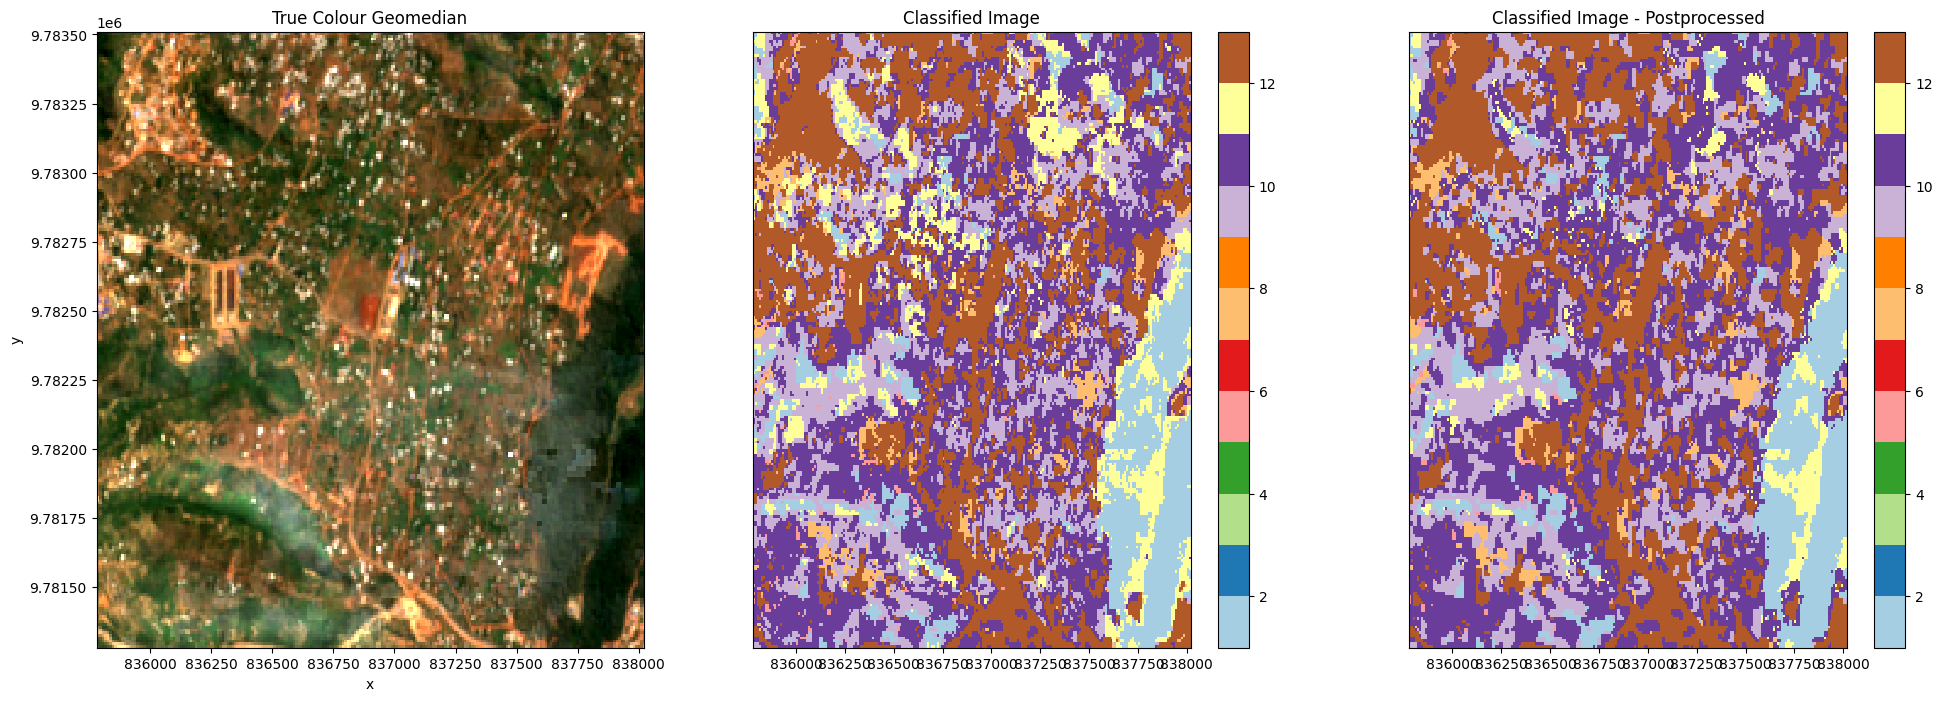

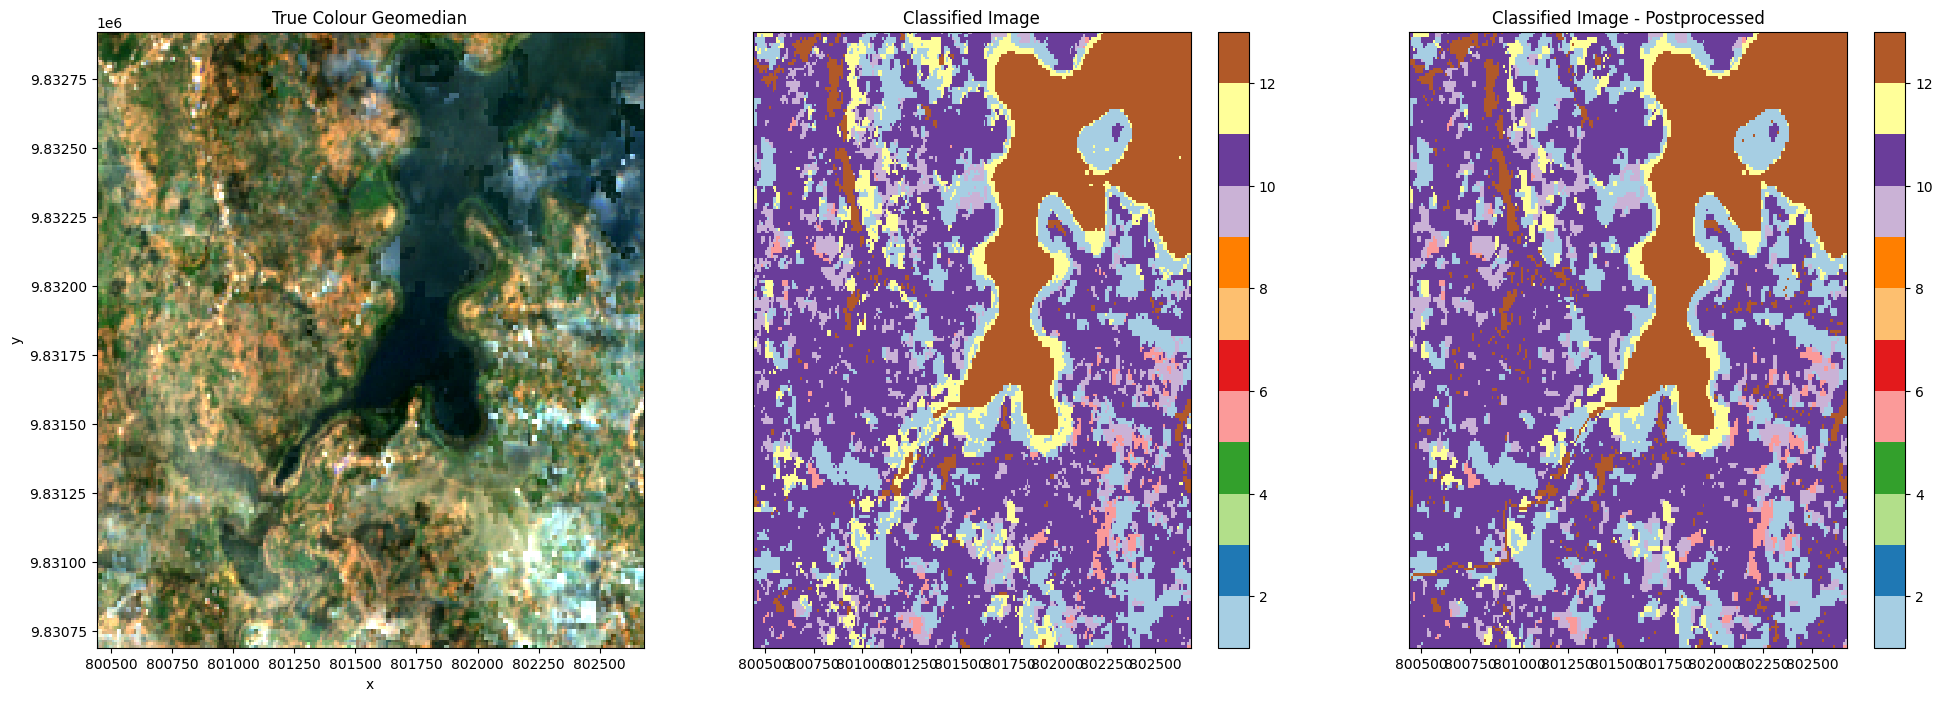

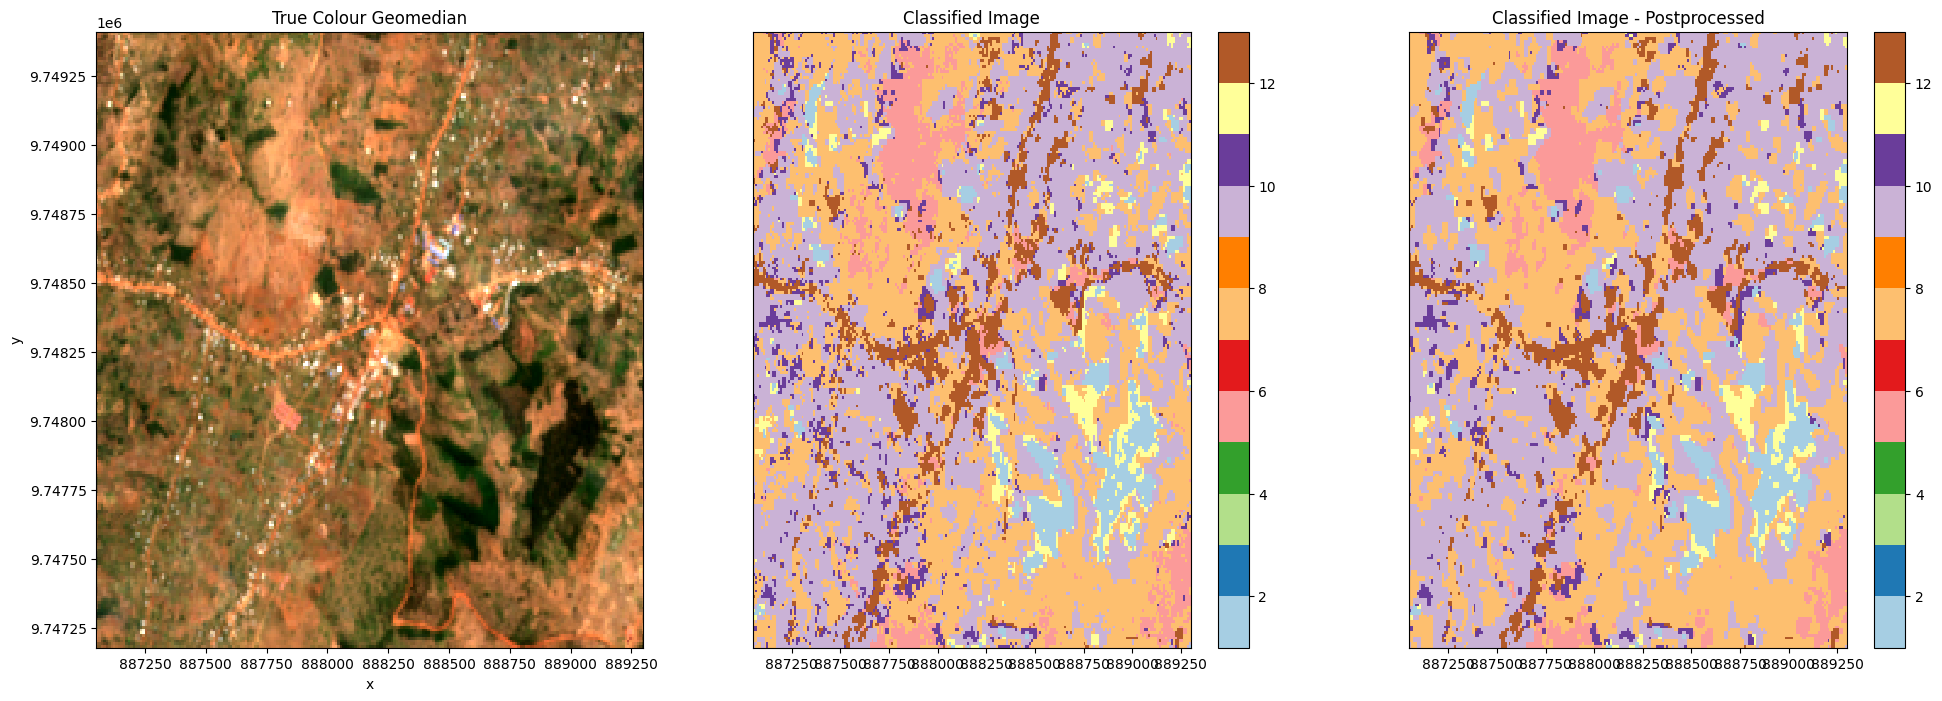

In [44]:
for i in range(0, len(prediction_maps)):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # Plot true colour image
    rgb(rgb_images[i].to_dataset(dim='band'),bands=[1,2,3],
        ax=axes[0], percentile_stretch=(0.01, 0.99))
    
    # todo: show the class names instead of values for better intepretation
    # todo: highest value class not shown?
    # Plot initial classified image
    prediction_maps[i].plot(ax=axes[1],
#                                     cmap=ListedColormap(colours),
                                    cmap='Paired',
                                    add_labels=False, 
#                                     add_colorbar=True,
#                                     levels=list(dict_map.keys())
                                    )
    
    # Plot post-processed classified image
    prediction_maps_postproc[i].plot(ax=axes[2],
#                                     cmap=ListedColormap(colours),
                                    cmap='Paired',
                                    add_labels=False, 
#                                     add_colorbar=True,
#                                     levels=list(dict_map.keys())
                                    )
    # Remove axis on middle and right plot
    axes[1].get_yaxis().set_visible(False)
    axes[2].get_yaxis().set_visible(False)
    # Add plot titles
    axes[0].set_title('True Colour Geomedian')
    axes[1].set_title('Classified Image')
    axes[2].set_title('Classified Image - Postprocessed')

## Save as geotiff
We can now export our post-processed results to sandbox disk as Cloud-Optimised GeoTIFFs:

In [45]:
for i in range(0, len(prediction_maps_postproc)):
    write_cog(prediction_maps_postproc[i], 'Results/Rwanda_land_cover_prediction_postprocessed_2021_location_'+str(i)+'.tif', overwrite=True)